# <u><center>LSTM and GRU Models (Core)
- Authored by: Eric N Valdez
- Date: 4/8/2024

- This assignment continues to use the [dataset](https://drive.google.com/file/d/1uUtuiAM1AqGvDMrd3-L8vLFfHPrt3pWG/view) from the practice assignment. This is the "spooky" dataset and represents passages from three famous authors: Edgar Allan Poe, HP Lovecraft, and Mary Shelley. The ultimate goal is a multi-class text classification matching each passage to the correct author.
- `You may wish to start with the notebook from the Vectorization Layer Practice. In the practice assignment, you should have already:`

## From Practice Assignment: Vectorization Layer

# <u>Imports

In [1]:
# From source: https://keras.io/examples/keras_recipes/reproducibility_recipes/
import tensorflow as tf
import numpy as np

# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler

## `Prepare the Dataset:`

In [3]:
# Load in the dataset with 'id" as the index column
df = pd.read_csv("Data/spooky.csv", index_col = 'id')
df.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
# Determine the sequence length of each document in the corpus by using a lambda function to split the text on the spaces
# Looking at the length of the each text
# Splitting on each space, and then getting the length
df['sequence_length'] =df['text'].map( lambda x: len(x.split(" ")))
df.head()

,text,author,sequence_length
id,,,
id26305,"This process, however, afforded me no means of...",EAP,41
id17569,It never once occurred to me that the fumbling...,HPL,14
id11008,"In his left hand was a gold snuff box, from wh...",EAP,36
id27763,How lovely is spring As we looked from Windsor...,MWS,34
id12958,"Finding nothing else, not even gold, the Super...",HPL,27


In [5]:
# What is the range of sequence lengths?
df['sequence_length'].describe()

count    19579.000000
mean        26.730477
std         19.048353
min          2.000000
25%         15.000000
50%         23.000000
75%         34.000000
max        861.000000
Name: sequence_length, dtype: float64

- The range of sequence length is from 2 to 861 terms.### What is the average sequence length?
- 
The average length is about 28 words.

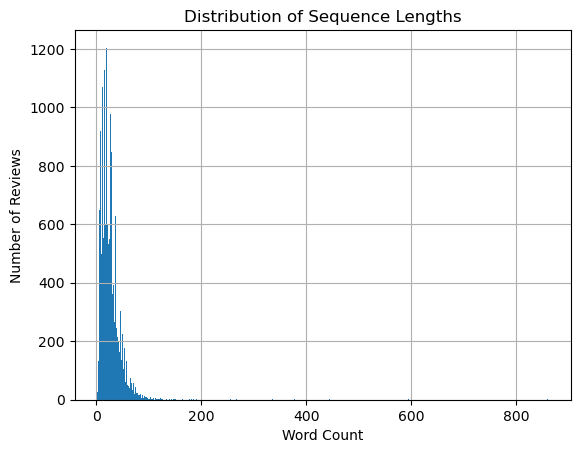

In [6]:
# Make histogram of sequence lengths
ax = df['sequence_length'].hist(bins = 'auto')
ax.set_xlabel('Word Count')
ax.set_ylabel('Number of Reviews')
ax.set_title('Distribution of Sequence Lengths');

In [7]:
# Use the RandomUnderSampler to balance the data based on the "author" column.
df['author'].value_counts(normalize = True)

EAP    0.403494
MWS    0.308698
HPL    0.287808
Name: author, dtype: float64

In [8]:
# Use RUS to reduce n to match minority group
sampler = RandomUnderSampler(random_state=42)
df,  _ = sampler.fit_resample(df, df['author'])
df['author'].value_counts()

EAP    5635
HPL    5635
MWS    5635
Name: author, dtype: int64

In [9]:
# Change the author strings to integers using the following mapping:
## EAP: 0, HPL: 1, MWS: 2, Creating the map for targets
target_map = {'EAP':0,
             'HPL':1,
             'MWS':2}
y = df['author'].map(target_map)
y

id
id22483    0
id18809    0
id16322    0
id13423    0
id09553    0
          ..
id22356    2
id11504    2
id00149    2
id16796    2
id23776    2
Name: author, Length: 16905, dtype: int64

In [10]:
# Define X as the values from the "text" column.
X = df['text'].values
X

array(['He then asked me, suddenly, if I had observed any thing peculiar at the scene of the atrocity.',
       'Through the exertions of Beauvais, the matter was industriously hushed up, as far as possible; and several days had elapsed before any public emotion resulted.',
       'The cold was intense, and obliged me to wrap up closely in an overcoat.',
       ...,
       'What I ask of you is reasonable and moderate; I demand a creature of another sex, but as hideous as myself; the gratification is small, but it is all that I can receive, and it shall content me.',
       'The birth of her daughter, embryo copy of her Raymond, filled up the measure of her content, and produced a sacred and indissoluble tie between them.',
       "I heard my sister's sobs, and thought, happy are women who can weep, and in a passionate caress disburthen the oppression of their feelings; shame and habitual restraint hold back a man."],
      dtype=object)

In [11]:
# Define y as the "author" column.
y.value_counts(normalize = True)

0    0.333333
1    0.333333
2    0.333333
Name: author, dtype: float64

In [12]:
classes = y.unique()
classes

array([0, 1, 2], dtype=int64)

In [13]:
# Convert to a dataset object using Dataset.from_tensor_slices()
ds = tf.data.Dataset.from_tensor_slices((X, y))

# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False) 

In [14]:
# Train, val, test, split with a .7, .2, .1 ratio using the take, skip, approach
## Add batching to all 3 splits using a batch size of 32.

# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )

# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

# Set the batch size
BATCH_SIZE =32


import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)

print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	11833 samples 	(370 batches)
    - val:  	3381 samples 	(106 batches)
    - test: 	1691 samples 	(53 batches)


In [15]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)

# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)

# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [16]:
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 370 training batches.
 There are 106 validation batches.
 There are 53 testing batches.


In [17]:
# Build a text vectorization layer to create integer sequences of each text.
## Use an output sequence length of 100, Use a standardization method of "lower_and_strip_punctuation
SEQUENCE_LENGTH = 100
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [18]:
# Obtain the text from the training dataset using a lambda function
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

# Preview the text
ds_texts.take(1).get_single_element()

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'And this was in truth the Death of which these bystanders spoke reverently, in low whispers you, sweet Una, gaspingly, with loud cries.',
       b'Had my eyes deceived me?',
       b"For some distance the line kept on along the gorge's brink, but at length I reached the long covered bridge where it crossed the chasm at a dizzy height.",
       b'The two forces mingling, unarmed and hand in hand, talking only how each might assist the other, the adversaries conjoined; each repenting, the one side their former cruelties, the other their late violence, they obeyed the orders of the General to proceed towards London.',
       b'I have already put off the carelessness of childhood, the unlined brow, and springy gait of early years, that they may adorn thee.',
       b'Idleness had ever been irksome to me, and now that I wished to fly from reflection, and hated my former studies, I felt great relief in being the fellow pupil with my frie

In [19]:
# Train (adapt) the vectorization layer on the text data
# Train (adapt on training text data))
sequence_vectorizer.adapt(ds_texts)
sequence_vectorizer.vocabulary_size()

20976

In [20]:
# # What is the size of the vocabulary?
# VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
# VOCAB_SIZE

In [21]:
# # Create a look-up dictionary that will allow you to look up the word associated with an integer.
# # Getting list of vocab
# vocab = sequence_vectorizer.get_vocabulary()
# int_to_str = {idx: word for idx, word in enumerate(vocab)}
# int_to_str


In [22]:
# # What term corresponds to 1000?
# int_to_str[1000]

In [23]:
# # Obtain the vectorized result of the sample text: "Text Vectorization is an essential tool for converting
# ## text into a format that machine learning models can use."
# sequence= sequence_vectorizer(['Text Vectorization is an essential tool for converting \
# text into a format that machine learning models can use.'])
# sequence

Custom Function:

In [24]:
# PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


In [25]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

In [26]:
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])
    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()
    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):
        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]
        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass
        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)
    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

In [27]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

In [28]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

In [29]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

20976

In [30]:
SEQUENCE_LENGTH = 400
SEQUENCE_LENGTH

400

In [31]:
# Define output dimension
EMBED_DIM = 150
EMBED_DIM

150

In [33]:
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import classification_report, ConfusionMatrixDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

      

def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])
    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()
    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):
        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]
        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass
        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)
    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)


def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

# Part 2 Core LSTM & GRU Model

## `1) LSTM`
- Define a function to build and compile a simple LSTM model
    - Use the pre-trained text vectorization layer from the Practice assignment above
    - Create an embedding layer with output_dim = 150
    - Add LSTM layer with 128 units
    - Add an appropriate output layer
    - Compile the model with the adam optimizer, loss = "sparse _categorical_corssentropy" and metrics = "accuracy"
    - Include an early stopping callback with a patience of 3
- Build, Fit, and Evaluate the Model.

In [57]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))
# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False)

In [58]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)
# Set the batch size
BATCH_SIZE =32
import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	11833 samples 	(370 batches)
    - val:  	3381 samples 	(106 batches)
    - test: 	1691 samples 	(53 batches)


In [59]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [60]:
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 370 training batches.
 There are 106 validation batches.
 There are 53 testing batches.


In [64]:
# Define sequence length as a variable for future use
SEQUENCE_LENGTH = 400
# # Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
# sequence_vectorizer, vocab_lookup = fn.make_text_vectorization_layer(train_ds, output_mode='int', \
#                                                                      output_sequence_length = SEQUENCE_LENGTH, verbose=True)

In [65]:
# Check the size of the vocabulary
VOCAB_SIZE = len(sequence_vectorizer.get_vocabulary())
VOCAB_SIZE

20976

In [66]:
# Get the size of the vocabulary
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

20976

In [67]:
# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_lstm_model(text_vectorization_layer):
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=150, #EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    lstm_model.add(layers.LSTM(128))
    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    lstm_model.summary()
    return lstm_model

In [68]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_9 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 lstm_1 (LSTM)               (None, 128)               142848    
                                                                 
 dense_6 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,289,635
Trainable params: 3,289,635
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
370/370 [==============================] - 53s 136ms/step - loss: 1.1066 - accuracy: 0.3342 - val_l

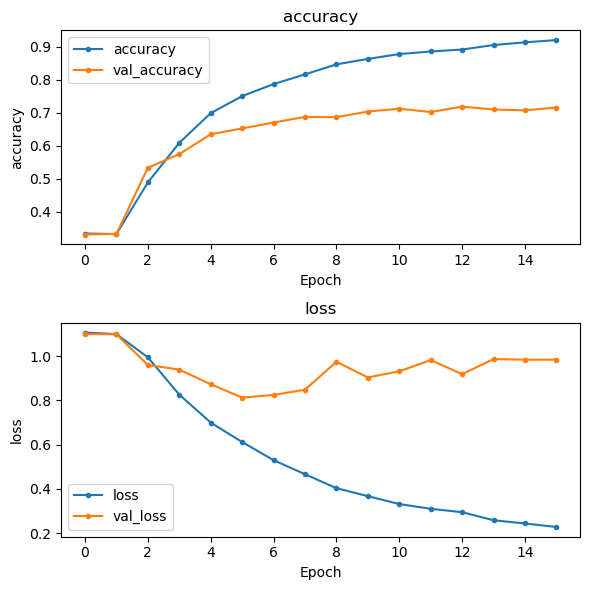


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3938
           1       0.97      0.95      0.96      3918
           2       0.93      0.94      0.93      3977

    accuracy                           0.93     11833
   macro avg       0.93      0.93      0.93     11833
weighted avg       0.93      0.93      0.93     11833



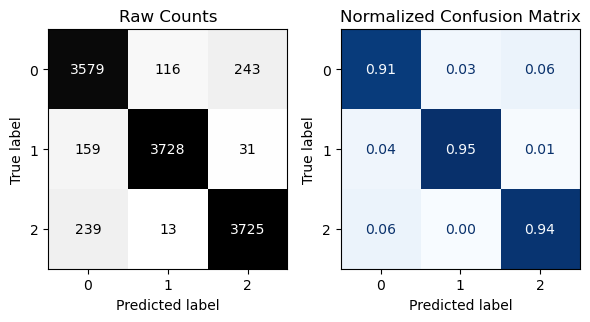


- Evaluating Training Data:
370/370 [==============================] - 12s 33ms/step - loss: 0.1959 - accuracy: 0.9323
{'loss': 0.19594167172908783, 'accuracy': 0.9323079586029053}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.67      0.64       554
           1       0.81      0.79      0.80       599
           2       0.76      0.71      0.73       538

    accuracy                           0.72      1691
   macro avg       0.73      0.72      0.72      1691
weighted avg       0.73      0.72      0.73      1691



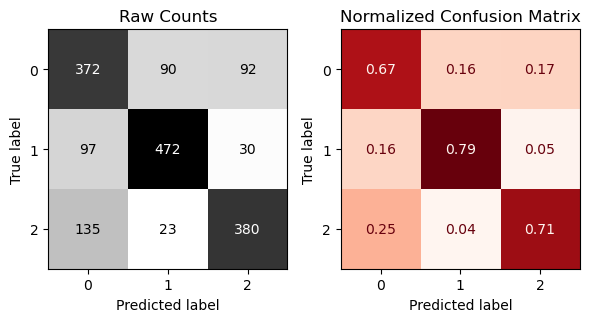


- Evaluating Test Data:
53/53 [==============================] - 2s 33ms/step - loss: 0.8889 - accuracy: 0.7238
{'loss': 0.8888896703720093, 'accuracy': 0.7238320708274841}


In [70]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)
# Defien number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Obtain the results
results = evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds, history=history
);

## `2) GRU`
- Defing a function to build and compile a simple GRU model
    - Follow the same steps as above, but instead of an LSTM layer use a GRU layer
- Build, Fit, and Evaluate the Model.

In [39]:
# Defining an embedding layer
embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)

In [40]:
# Confirm these values
print(f' VOCAB_SIZE: {VOCAB_SIZE}')
print(f' EMBED_DIM: {EMBED_DIM}')
print(f' SEQUENCE_LENGTH: {SEQUENCE_LENGTH}')

 VOCAB_SIZE: 20976
 EMBED_DIM: 150
 SEQUENCE_LENGTH: 400


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_gru_model(text_vectorization_layer):
                
    gru_model = Sequential([
        text_vectorization_layer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])
    # Add GRU layer *new*
    gru_model.add(layers.GRU(128, return_sequences = True))   
    gru_model.add(layers.GlobalMaxPooling1D())
    # Output layer
    gru_model.add(layers.Dense(len(classes), 
                              activation='softmax'))
        
    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

In [42]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 gru (GRU)                   (None, 100, 128)          107520    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,254,307
Trainable params: 3,254,307
No

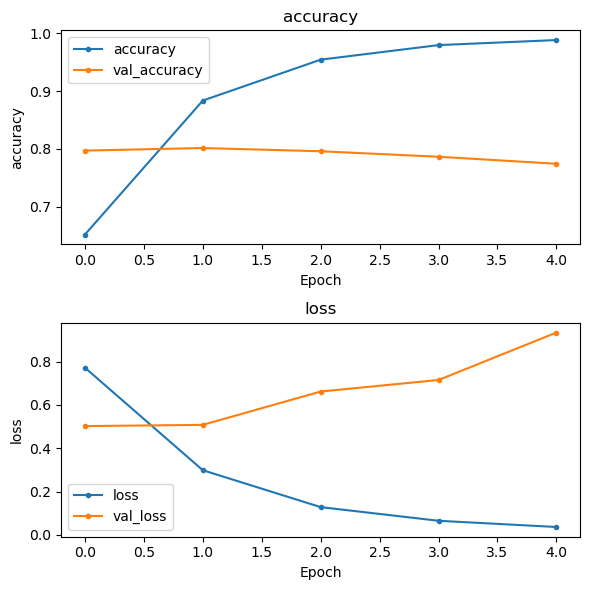


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3906
           1       1.00      0.99      0.99      3952
           2       0.98      1.00      0.99      3975

    accuracy                           0.99     11833
   macro avg       0.99      0.99      0.99     11833
weighted avg       0.99      0.99      0.99     11833



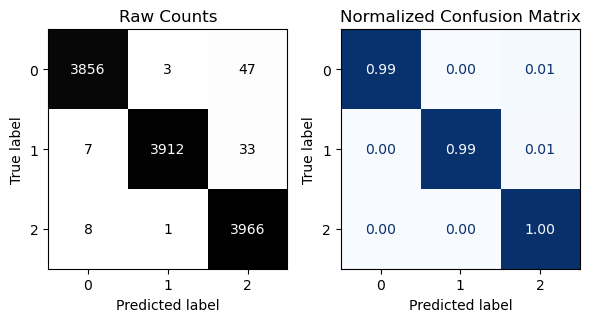


- Evaluating Training Data:
370/370 [==============================] - 10s 28ms/step - loss: 0.0292 - accuracy: 0.9916
{'loss': 0.029211396351456642, 'accuracy': 0.9916335940361023}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       559
           1       0.85      0.73      0.78       560
           2       0.72      0.90      0.80       572

    accuracy                           0.78      1691
   macro avg       0.79      0.78      0.78      1691
weighted avg       0.79      0.78      0.78      1691



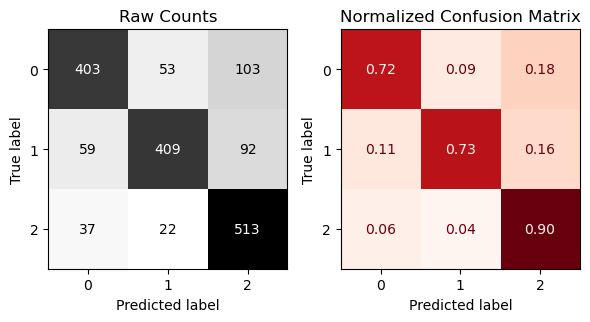


- Evaluating Test Data:
53/53 [==============================] - 2s 29ms/step - loss: 0.8984 - accuracy: 0.7836
{'loss': 0.8984168767929077, 'accuracy': 0.783560037612915}


In [43]:
# Build the model
model = build_gru_model(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Evaluate the model
results = evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);